In [1]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB 73.1 kB/s eta 0:02:55
     ---------------------------------------- 0.0/12.8 MB 73.1 kB/s eta 0:02:55
     ---------------------------------------- 0.0/12.8 MB 73.1 kB/s eta 0:02:55
     ---------------------------------------- 0.0/12.8 MB 73

In [22]:
#IMPORT THE NEEDED PACKGES FOR Accomplishing this ML program.
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from afinn import Afinn
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [3]:
# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hani1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hani1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hani1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hani1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hani1\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Define file paths for the datasets
filepath = r"C:\Users\hani1\Downloads\Train.csv"
test_filepath = r"C:\Users\hani1\Downloads\test.csv"

# Load the datasets
df = pd.read_csv(filepath, encoding='windows-1252')
test_df = pd.read_csv(test_filepath, encoding='windows-1252')


In [5]:
# Initialize necessary NLTK tools and sentiment analyzers
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()
afinn = Afinn()

In [6]:
# Define dictionaries of words with sentiment and negations
negative_words = {'bad', 'terrible', 'horrible', 'sad', 'negative', 'not', 'no', 'never', 'angry', 'disgust', 'fear', 'hate', 'pain', 'sick', 'ugly', 'unhappy', 'worse', 'worst'}
positive_words = {'good', 'great', 'excellent', 'awesome', 'happy', 'positive', 'yes', 'love', 'joy', 'pleasure', 'smile', 'wonderful', 'fantastic', 'amazing', 'delight', 'peace', 'beautiful', 'best', 'better'}
negation_words = {'not', 'no', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere', 'hardly', 'scarcely', 'barely', 'doesn’t', 'isn’t', 'wasn’t', 'shouldn’t', 'wouldn’t', 'couldn’t', 'won’t', 'can’t', 'don’t', 'didn’t', 'hasn’t', 'haven’t', 'aren’t'}

In [7]:
# Function to handle negations in text
def handle_negations(text):
    words = word_tokenize(text)
    negation = False
    adjusted_words = []
    for word in words:
        if word in negation_words:
            negation = True
        elif negation:
            word = "not_" + word
            negation = False
        adjusted_words.append(word)
    return ' '.join(adjusted_words)

# Function to preprocess text data
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@[^\s]+', '', text)  # Remove mentions
    text = re.sub(r'[^\w\s!?]', '', text)  # Remove punctuation except for ! and ?
    text = handle_negations(text)  # Handle negations
    words = word_tokenize(text)  # Tokenize text
    words = [word for word in words if word not in stop_words and len(word) > 1]  # Remove stop words and short words
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize words
    return ' '.join(words)

# Function to get VADER sentiment scores
def get_sentiment_scores(text):
    sia_scores = sia.polarity_scores(text)  # Get VADER sentiment scores
    words = word_tokenize(text)  # Tokenize text
    negation = False
    for word in words:
        if word in negation_words:
            negation = True
        elif negation and sia.polarity_scores(word)['compound'] != 0:
            word_scores = sia.polarity_scores(word)
            sia_scores['neg'] += word_scores['pos']
            sia_scores['pos'] += word_scores['neg']
            sia_scores['compound'] -= word_scores['compound']
            negation = False
    return sia_scores

# Function to get Afinn sentiment score
def get_afinn_score(text):
    return afinn.score(text)

# Function to count words from a specific dictionary in the text
def get_word_count(text, dictionary):
    words = word_tokenize(text)
    return len([word for word in words if word in dictionary])

# Function to count specific punctuation marks in the text
def get_punctuation_marks_count(text):
    punctuation_marks = {'!': 'exclamation', '?': 'question', '!?': 'exclamation_question', '?!': 'question_exclamation'}
    return len([char for char in text if char in punctuation_marks])

# Function to get user interaction features from the text
def get_user_interaction_features(text):
    return {
        'likes_count': text.count('like'),
        'retweets_count': text.count('retweet'),
        'replies_count': text.count('reply'),
        'mentions_count': text.count('@')
    }

# Function to get POS tags and their frequencies in the text
def get_pos_tags(text):
    words = word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    pos_counts = FreqDist(tag for (word, tag) in pos_tags)
    return pos_counts

# Function to clean and preprocess the dataset
def clean_data(df):
    df.drop_duplicates(inplace=True)  # Drop duplicate rows
    df.dropna(inplace=True)  # Drop rows with missing values
    df['clean_text'] = df['SentimentText'].apply(preprocess_text)  # Preprocess text
    df['sentiment_scores'] = df['SentimentText'].apply(get_sentiment_scores)  # Get VADER sentiment scores
    df['afinn_score'] = df['SentimentText'].apply(get_afinn_score)  # Get Afinn sentiment score
    df['negative_words_count'] = df['SentimentText'].apply(lambda text: get_word_count(text, negative_words))  # Count negative words
    df['positive_words_count'] = df['SentimentText'].apply(lambda text: get_word_count(text, positive_words))  # Count positive words
    df['punctuation_marks_count'] = df['SentimentText'].apply(get_punctuation_marks_count)  # Count punctuation marks
    user_interaction_features = df['SentimentText'].apply(get_user_interaction_features)
    df['likes_count'] = user_interaction_features.apply(lambda x: x['likes_count'])  # Add likes count
    df['retweets_count'] = user_interaction_features.apply(lambda x: x['retweets_count'])  # Add retweets count
    df['replies_count'] = user_interaction_features.apply(lambda x: x['replies_count'])  # Add replies count
    df['mentions_count'] = user_interaction_features.apply(lambda x: x['mentions_count'])  # Add mentions count
    df['pos_tags'] = df['SentimentText'].apply(get_pos_tags)  # Add POS tag counts
    return df

In [8]:
# Clean the data
df_cleaned = clean_data(df)


In [9]:
# Extract sentiment scores into separate columns
df_cleaned = pd.concat([df_cleaned.drop(['sentiment_scores'], axis=1), df_cleaned['sentiment_scores'].apply(pd.Series)], axis=1)

# Extract POS tag counts into separate columns
pos_tag_columns = list(set(tag for tags in df_cleaned['pos_tags'] for tag in tags.keys()))
for column in pos_tag_columns:
    df_cleaned[column] = df_cleaned['pos_tags'].apply(lambda tags: tags[column] if column in tags else 0)
df_cleaned.drop(columns=['pos_tags'], inplace=True)

# Function to add LDA topic features
def add_topic_features(df, n_topics=10):
    lda_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
    lda_X = lda_vectorizer.fit_transform(df['clean_text'])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_topics = lda.fit_transform(lda_X)
    topic_columns = [f'topic_{i}' for i in range(n_topics)]
    topic_df = pd.DataFrame(lda_topics, columns=topic_columns)
    df = pd.concat([df.reset_index(drop=True), topic_df], axis=1)
    return df

# Add topic features to the cleaned dataset
df_cleaned = add_topic_features(df_cleaned)

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Feature extraction using TF-IDF (sparse matrix)
tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2), use_idf=True, smooth_idf=True)
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['clean_text'])

# Add tweet length and sentiment scores as features
df_cleaned['tweet_length'] = df_cleaned['clean_text'].apply(len)  # Calculate tweet length
additional_features = df_cleaned[['tweet_length', 'neg', 'neu', 'pos', 'compound', 'afinn_score', 'negative_words_count', 'positive_words_count', 'punctuation_marks_count', 'likes_count', 'retweets_count', 'replies_count', 'mentions_count'] + pos_tag_columns + [f'topic_{i}' for i in range(10)]].values
X_tfidf_with_additional = np.hstack((X_tfidf.toarray(), additional_features))  # Combine TF-IDF and additional features


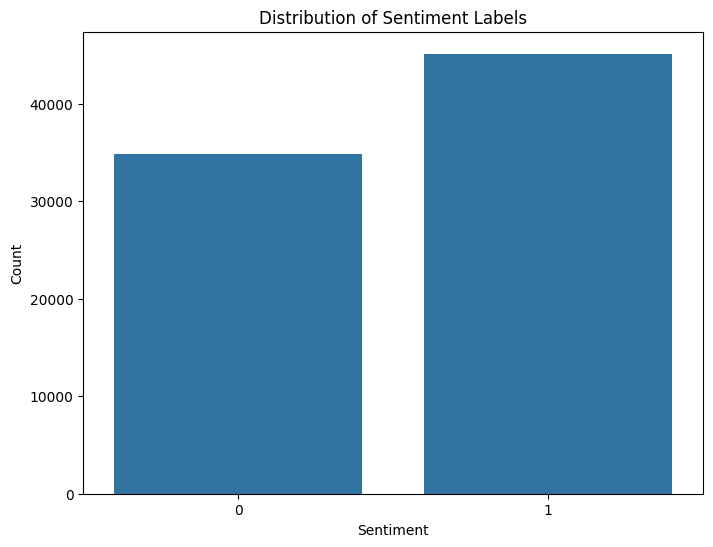

In [10]:
# EDA: Distribution of Sentiment Labels
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

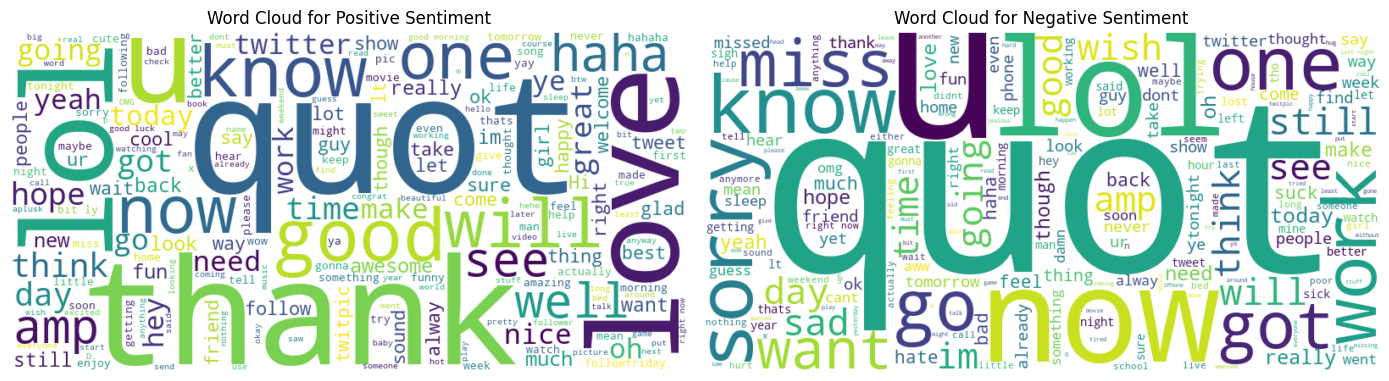

In [11]:
# EDA: Combined Word Cloud for Positive and Negative Sentiments
positive_text = ' '.join(df[df['Sentiment'] == 1]['SentimentText'])
negative_text = ' '.join(df[df['Sentiment'] == 0]['SentimentText'])

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot the word clouds side by side
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

plt.tight_layout()
plt.show()


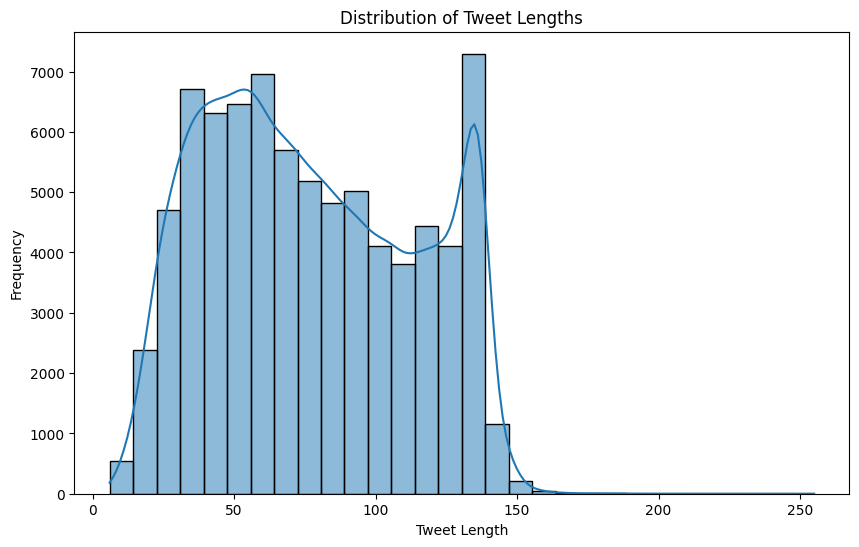

In [12]:
# EDA: Distribution of Tweet Lengths
df['tweet_length'] = df['SentimentText'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


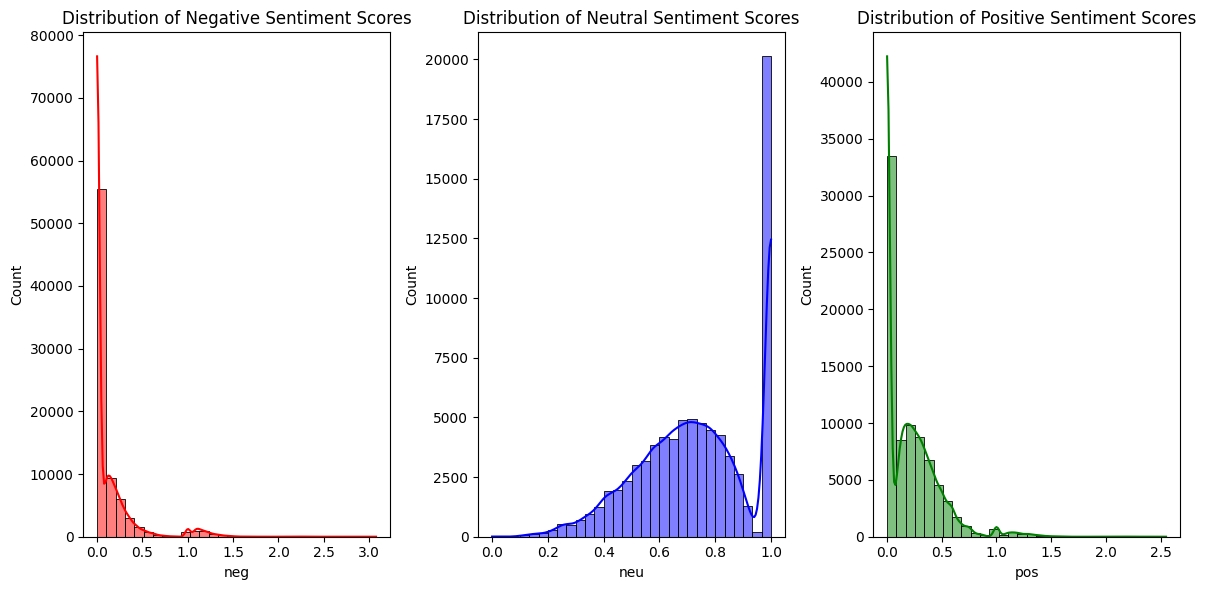

In [13]:
# EDA: Distribution of Sentiment Scores
df['sentiment_scores'] = df['SentimentText'].apply(get_sentiment_scores)
sentiment_df = pd.json_normalize(df['sentiment_scores'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(sentiment_df['neg'], bins=30, kde=True, color='red')
plt.title('Distribution of Negative Sentiment Scores')

plt.subplot(1, 3, 2)
sns.histplot(sentiment_df['neu'], bins=30, kde=True, color='blue')
plt.title('Distribution of Neutral Sentiment Scores')

plt.subplot(1, 3, 3)
sns.histplot(sentiment_df['pos'], bins=30, kde=True, color='green')
plt.title('Distribution of Positive Sentiment Scores')

plt.tight_layout()
plt.show()


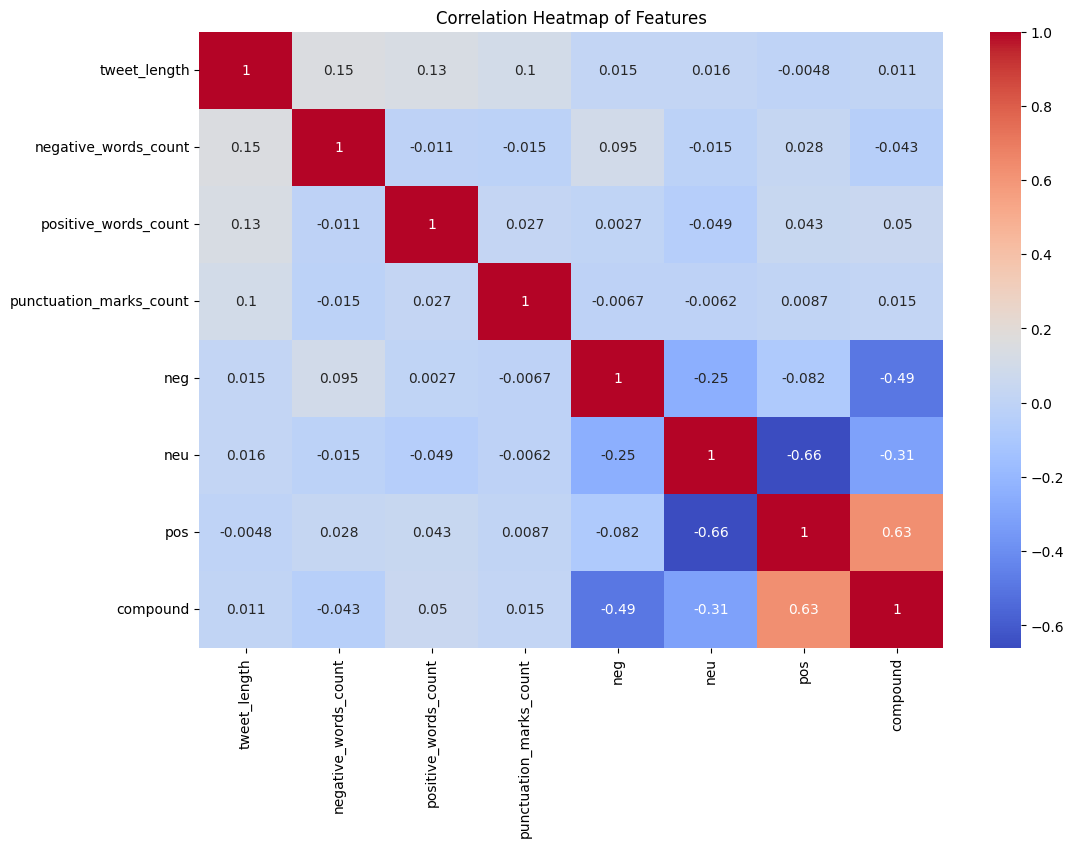

In [14]:
# EDA: Correlation Heatmap
correlation_features = df[['tweet_length', 'negative_words_count', 'positive_words_count', 'punctuation_marks_count']]
correlation_features = pd.concat([correlation_features, sentiment_df], axis=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_features.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

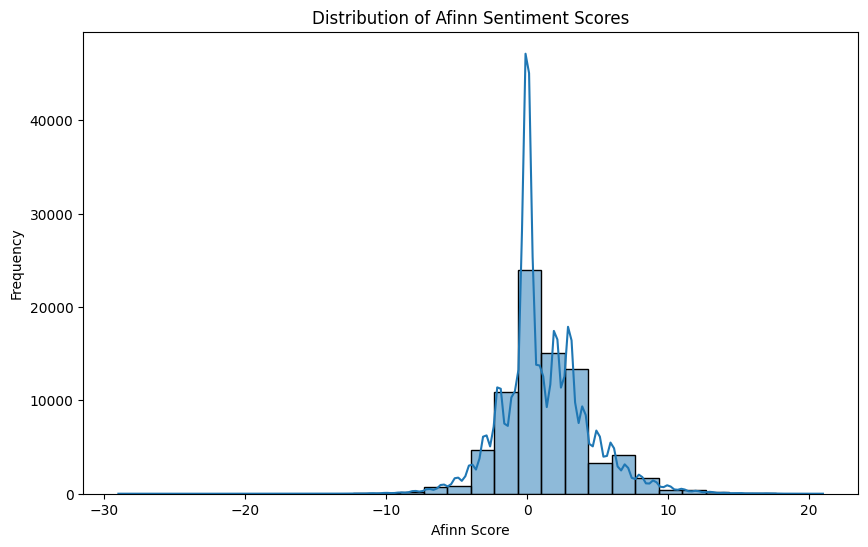

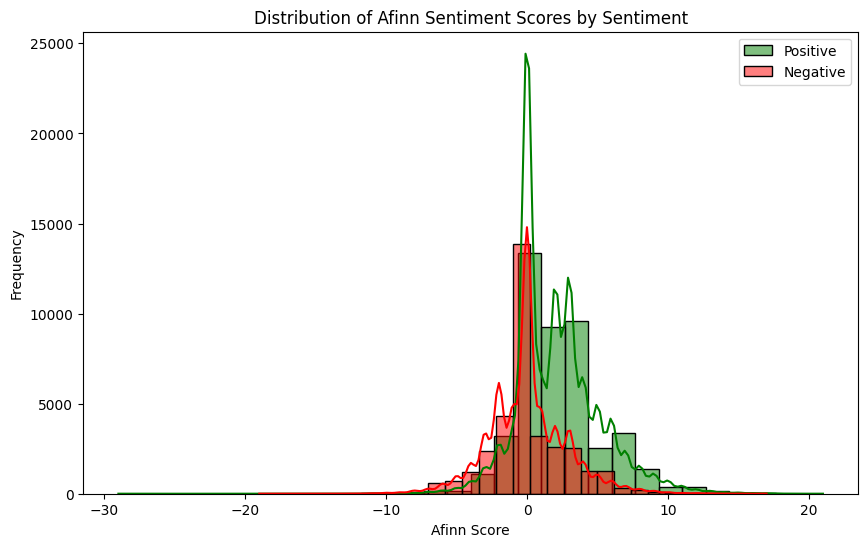

In [15]:
# EDA: Distribution of Afinn Scores
df['afinn_score'] = df['SentimentText'].apply(get_afinn_score)

plt.figure(figsize=(10, 6))
sns.histplot(df['afinn_score'], bins=30, kde=True)
plt.title('Distribution of Afinn Sentiment Scores')
plt.xlabel('Afinn Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df[df['Sentiment'] == 1]['afinn_score'], bins=30, kde=True, color='green', label='Positive')
sns.histplot(df[df['Sentiment'] == 0]['afinn_score'], bins=30, kde=True, color='red', label='Negative')
plt.title('Distribution of Afinn Sentiment Scores by Sentiment')
plt.xlabel('Afinn Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


C:\Users\hani1\AppData\Local\Temp\ipykernel_17032\1387850213.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, palette='viridis')


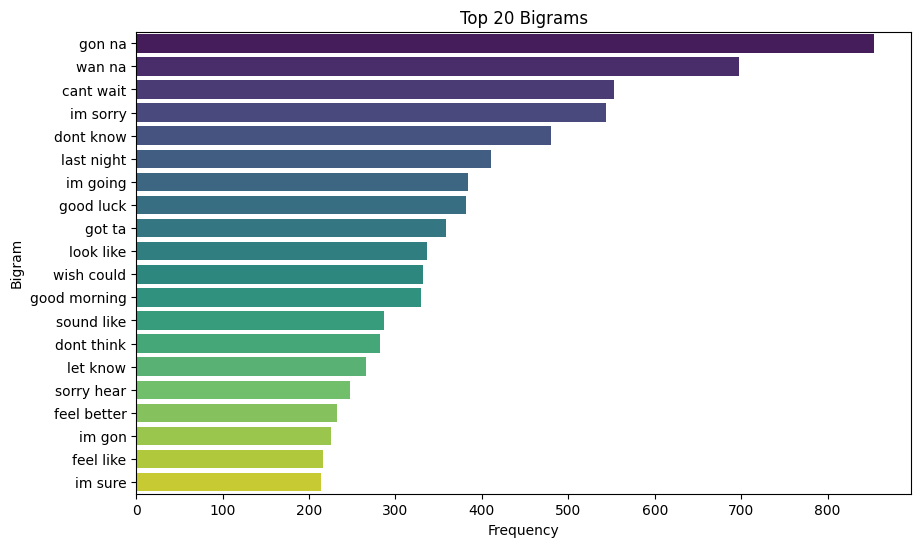

C:\Users\hani1\AppData\Local\Temp\ipykernel_17032\1387850213.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_positive_df, palette='viridis')


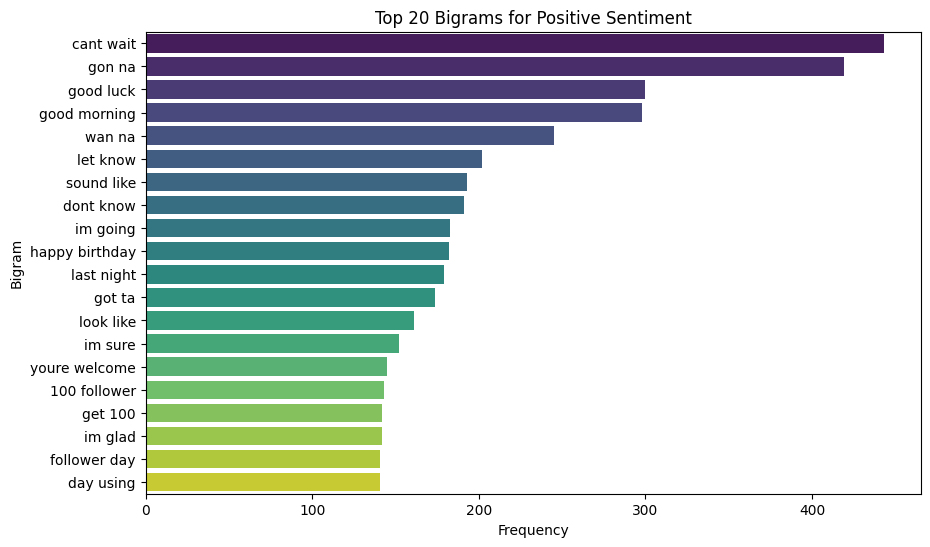

C:\Users\hani1\AppData\Local\Temp\ipykernel_17032\1387850213.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_negative_df, palette='viridis')


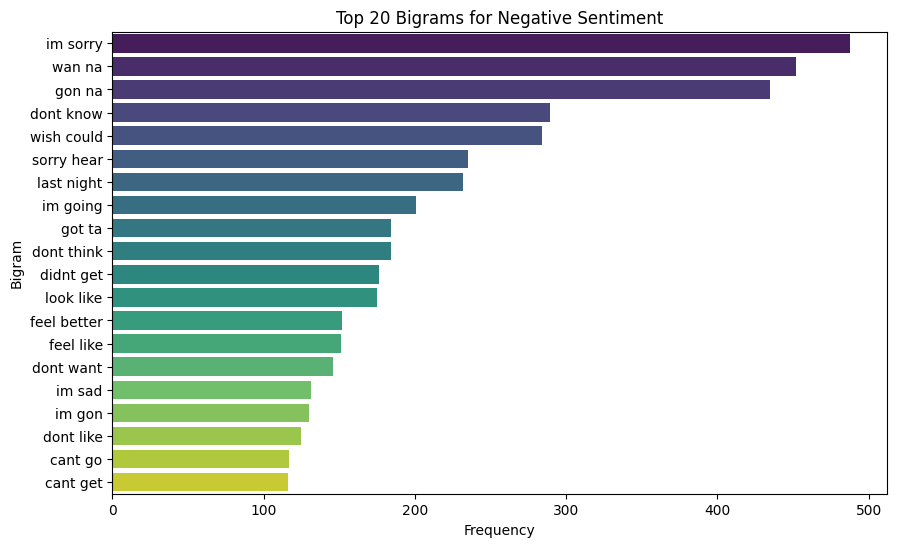

In [16]:
# EDA: Bigram Frequency Analysis
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams = get_top_bigrams(df['clean_text'], n=20)
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, palette='viridis')
plt.title('Top 20 Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

top_bigrams_positive = get_top_bigrams(df[df['Sentiment'] == 1]['clean_text'], n=20)
top_bigrams_positive_df = pd.DataFrame(top_bigrams_positive, columns=['Bigram', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_positive_df, palette='viridis')
plt.title('Top 20 Bigrams for Positive Sentiment')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

top_bigrams_negative = get_top_bigrams(df[df['Sentiment'] == 0]['clean_text'], n=20)
top_bigrams_negative_df = pd.DataFrame(top_bigrams_negative, columns=['Bigram', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_negative_df, palette='viridis')
plt.title('Top 20 Bigrams for Negative Sentiment')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()


In [17]:
# Standardize the features for LightGBM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tfidf_with_additional)

# Define the target variable
y = df_cleaned['Sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
# Hyperparameter tuning for LightGBM using RandomizedSearchCV
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}
lgb_model = lgb.LGBMClassifier()
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid, cv=3, scoring='f1', n_iter=10, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)


c:\Users\hani1\OneDrive\שולחן העבודה\322.zip\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hani1\OneDrive\שולחן העבודה\322.zip\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Number of positive: 36140, number of negative: 27854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.333676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66229
[LightGBM] [Info] Number of data points in the train set: 63994, number of used features: 566
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564740 -> initscore=0.260424
[LightGBM] [Info] Start training from score 0.260424


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'n_estimators': [100, 200],
                                        'num_leaves': [31, 50]},
                   random_state=42, scoring='f1')

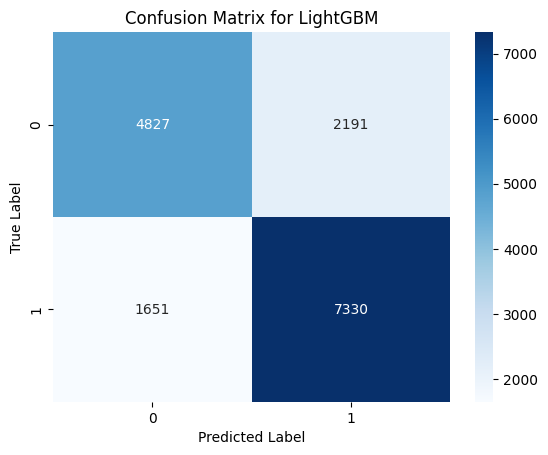

LightGBM Performance:
Best Parameters: {'num_leaves': 50, 'n_estimators': 200, 'learning_rate': 0.05}
Accuracy: 0.7598599912494531
Precision: 0.7698771137485558
Recall: 0.8161674646475894
F1 Score: 0.792346773321803


In [19]:
# Get the best model from RandomizedSearchCV
best_lgb_model = random_search.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_test)
# Confusion matrix for LightGBM
conf_matrix = confusion_matrix(y_test, y_pred_lgb)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for LightGBM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print("LightGBM Performance:")
print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("Precision:", precision_score(y_test, y_pred_lgb))
print("Recall:", recall_score(y_test, y_pred_lgb))
print("F1 Score:", f1_score(y_test, y_pred_lgb))




Logistic Regression Performance:
Accuracy: 0.7531095693480843
Precision: 0.7574455019957016
Recall: 0.8240730430909698
F1 Score: 0.7893558020477816


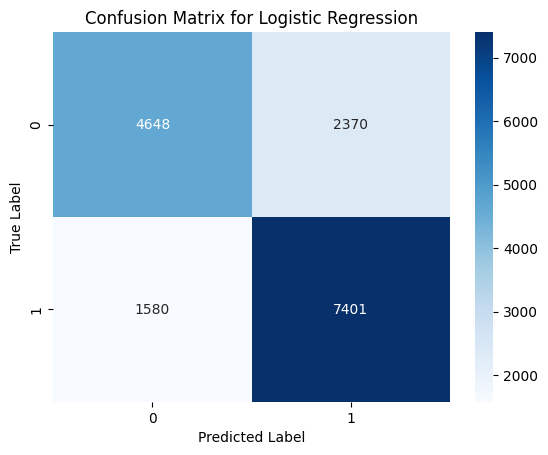

In [20]:
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict using Logistic Regression
y_pred_lr = lr_model.predict(X_test)

# Print Logistic Regression Performance
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))

# Confusion matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

c:\Users\hani1\OneDrive\שולחן העבודה\322.zip\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
Accuracy: 0.757047315457216
Precision: 0.7640472734812358
Recall: 0.8206213116579445
F1 Score: 0.7913244215386267


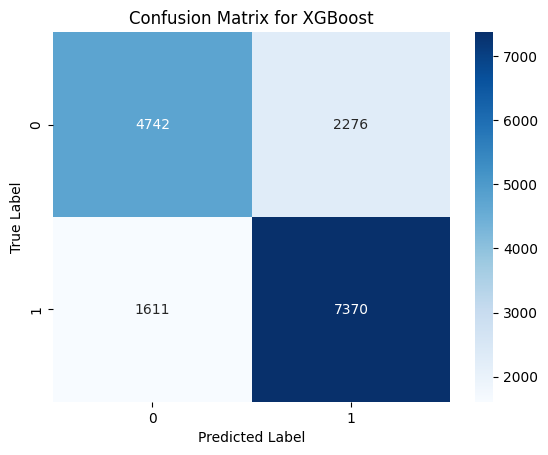

In [26]:
# XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Print XGBoost Performance
print("XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))

# Confusion matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Preprocess the test data
test_df['clean_text'] = test_df['SentimentText'].apply(preprocess_text)
test_df['sentiment_scores'] = test_df['SentimentText'].apply(get_sentiment_scores)
test_df['afinn_score'] = test_df['SentimentText'].apply(get_afinn_score)
test_df['negative_words_count'] = test_df['SentimentText'].apply(lambda text: get_word_count(text, negative_words))
test_df['positive_words_count'] = test_df['SentimentText'].apply(lambda text: get_word_count(text, positive_words))
test_df['punctuation_marks_count'] = test_df['SentimentText'].apply(get_punctuation_marks_count)
user_interaction_features_test = test_df['SentimentText'].apply(get_user_interaction_features)
test_df['likes_count'] = user_interaction_features_test.apply(lambda x: x['likes_count'])
test_df['retweets_count'] = user_interaction_features_test.apply(lambda x: x['retweets_count'])
test_df['replies_count'] = user_interaction_features_test.apply(lambda x: x['replies_count'])
test_df['mentions_count'] = user_interaction_features_test.apply(lambda x: x['mentions_count'])
test_df['pos_tags'] = test_df['SentimentText'].apply(get_pos_tags)


In [ ]:
# Extract sentiment scores into separate columns for the test data
test_df = pd.concat([test_df.drop(['sentiment_scores'], axis=1), test_df['sentiment_scores'].apply(pd.Series)], axis=1)

# Extract POS tag counts into separate columns for the test data
for column in pos_tag_columns:
    test_df[column] = test_df['pos_tags'].apply(lambda tags: tags[column] if column in tags else 0)
test_df.drop(columns=['pos_tags'], inplace=True)

# Add topic features to the test dataset
test_df = add_topic_features(test_df)

# Feature extraction using TF-IDF (sparse matrix) for the test data
X_test_tfidf_only = tfidf_vectorizer.transform(test_df['clean_text'])

# Add tweet length and sentiment scores as features for the test data
test_df['tweet_length'] = test_df['clean_text'].apply(len)
additional_features_test = test_df[['tweet_length', 'neg', 'neu', 'pos', 'compound', 'afinn_score', 'negative_words_count', 'positive_words_count', 'punctuation_marks_count', 'likes_count', 'retweets_count', 'replies_count', 'mentions_count'] + pos_tag_columns + [f'topic_{i}' for i in range(10)]].values
X_test_tfidf_with_additional = np.hstack((X_test_tfidf_only.toarray(), additional_features_test))


In [ ]:
# Standardize the features for the test data
X_test_scaled = scaler.transform(X_test_tfidf_with_additional)

# Predict using the best LightGBM model
test_predictions_lgb = best_lgb_model.predict(X_test_scaled)

# Save the predictions to a CSV file for submission
submission_df_lgb = pd.DataFrame({'ID': test_df['ID'], 'Sentiment': test_predictions_lgb})
submission_df_lgb.to_csv('submission_lgbbesTs.csv', index=False)
